In [1]:
import numpy as np
import scanpy as sc
import scvelo as scv
import torch
from umap import UMAP
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu

from deepvelo.utils import (
    velocity,
    velocity_confidence,
    continuity_confidence,
    update_dict,
    cross_boundary_correctness,
)
from deepvelo.utils.scatter import scatter
from deepvelo.utils.preprocess import autoset_coeff_s
from deepvelo.utils.plot import statplot, compare_plot
from deepvelo import train, Constants
import time

Using backend: pytorch
/home/tung/anaconda3/envs/deepvelo/lib/python3.8/site-packages/deepvelo/utils/scatter.py:5: DeprecationWarning: deepvelo.utils.scatter is deprecated. Please use deepvelo.plot.scatter instead.
  warnings.warn(
/home/tung/anaconda3/envs/deepvelo/lib/python3.8/site-packages/deepvelo/utils/plot.py:5: DeprecationWarning: deepvelo.utils.plot is deprecated. Please use deepvelo.plot.plot instead.
  warnings.warn(


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Filtered out 18710 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
The ratio of spliced reads is 75.4% (between 70% and 85%). Suggest using coeff_s 0.75.
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Config Warning: Set to use GPU, but GPU version of DGL is not installed. Reset to use CPU instead.
building graph


INFO:train:Beginning training of DeepVelo ...


velo data shape: torch.Size([18213, 2000])
confidence mse shape: (18213, 2000)
confidence mse stats: max 1109.931396484375, min 0.0, mean 0.2666265666484833, std 3.5642378330230713
confidence corr shape: (2000,)
confidence corr stats: max 0.8993812203407288, min -0.11579670011997223, mean 0.446072518825531, std 0.14505182206630707
velo_mat shape: (18213, 2000)
--> added 'velocity' (adata.layers)
--> added 'velocity_unspliced' (adata.layers)
--> added 'cell_specific_beta' (adata.layers)
--> added 'cell_specific_gamma' (adata.layers)
computing velocity graph (using 16/24 cores)


  0%|          | 0/18213 [00:00<?, ?cells/s]

    finished (0:00:12) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


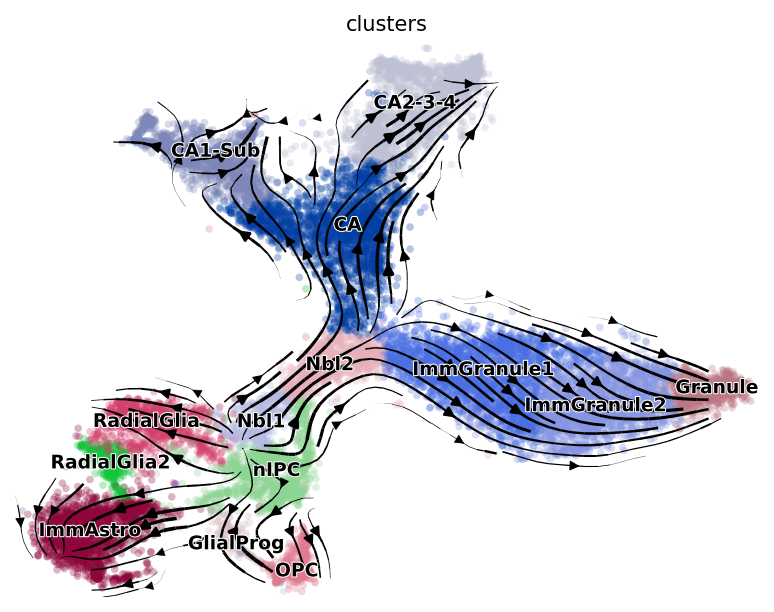

computing terminal states
    identified 3 regions of root cells and 4 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
7.540699672698975


In [2]:
start_time = time.time()

adata = scv.datasets.dentategyrus_lamanno()

scv.pp.filter_and_normalize(adata, min_shared_counts = 20, n_top_genes = 2000)
scv.pp.moments(adata, n_pcs = 30, n_neighbors = 30)

# specific configs to overide the default configs
configs = {
    "name": "DeepVelo", # name of the experiment
    "loss": {"args": {"coeff_s": autoset_coeff_s(adata)}},
    "trainer": {"verbosity": 0}, # increase verbosity to show training progress
}
configs = update_dict(Constants.default_configs, configs)

SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

velocity(adata, mask_zero=False)

trainer = train(adata, configs)

scv.tl.velocity_graph(adata, n_jobs=16)

scv.pl.velocity_embedding_stream(
    adata,
    basis="tsne",
    color="clusters",
    legend_fontsize=9,
    dpi=150            # increase dpi for higher resolution
)

scv.tl.velocity_pseudotime(adata)

end_time = time.time()
print((end_time - start_time) / 60)